In [ ]:

import pandas as pd

import pandas as pd
from google.colab import files

uploaded = files.upload()
uploaded1 = files.upload()
uploaded2 = files.upload()

Saving FsdET.csv to FsdET.csv


Saving MtnET.csv to MtnET.csv


Saving RwpET.csv to RwpET.csv


Make Violen Plot of Data set

<ipython-input-60-6113d2dfc25e>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='dataset', y=variable, data=pd.concat([FsdET_df, MtnET_df, RwpET_df]), palette='tab10')
<ipython-input-60-6113d2dfc25e>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='dataset', y=variable, data=pd.concat([FsdET_df, MtnET_df, RwpET_df]), palette='tab10')
<ipython-input-60-6113d2dfc25e>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='dataset', y=variable, data=pd.concat([FsdET_df, MtnET_df, RwpET_df]), palette='tab10')
<ipython-input-60-6113

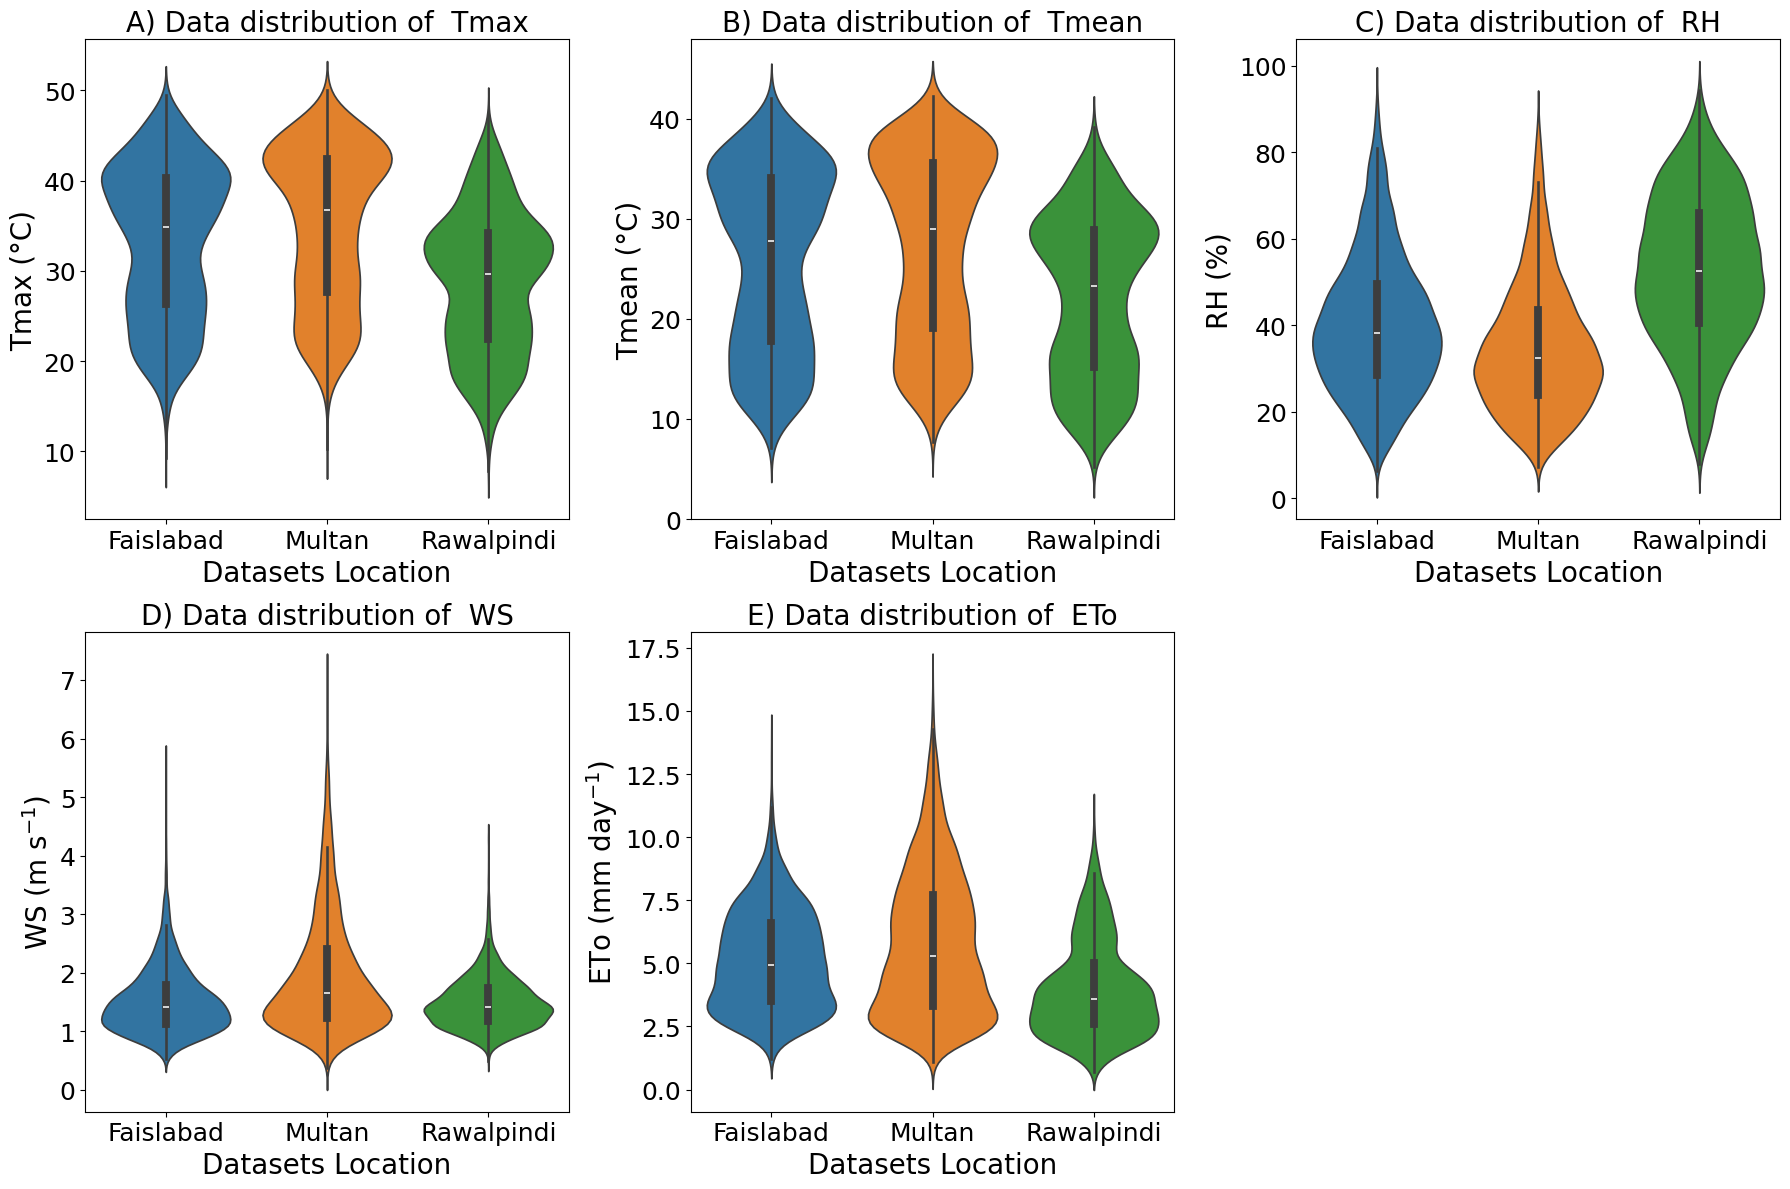

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset files
FsdET_df = pd.read_csv("FsdET.csv")
MtnET_df = pd.read_csv("MtnET.csv")
RwpET_df = pd.read_csv("RwpET.csv")

# Define variables to plot
variables = ['Tmax','Tmean', 'RH', 'WS', 'ETo']

# Replace dataset names
FsdET_df['dataset'] = 'Faislabad'
MtnET_df['dataset'] = 'Multan'
RwpET_df['dataset'] = 'Rawalpindi'

# Plot violin plots for each variable in each dataset
plt.figure(figsize=(18, 12))

for idx, variable in enumerate(variables, 1):
    plt.subplot(2, 3, idx)
    sns.violinplot(x='dataset', y=variable, data=pd.concat([FsdET_df, MtnET_df, RwpET_df]), palette='tab10')
    plt.title(f'{chr(64+idx)}) Data distribution of  {variable}', fontsize=20)
    plt.xlabel('Datasets Location', fontsize=20)
    plt.ylabel(f'{variable} ({"mm day$^{-1}$"})' if variable == 'ETo' else f'{variable} ({chr(176)}C)' if variable in ['Tmax', 'Tmean'] else f'{variable} (m {"s$^{-1}$"})' if variable == 'WS' else f'{variable} (%)', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

plt.tight_layout()
plt.show()





**Make Train local models**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def nash_sutcliffe_efficiency(y_true, y_pred):
    """
    Calculate the Nash–Sutcliffe model efficiency coefficient (NSE).
    """
    return 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))

# Load the CSV files for each dataset (FsdET, MtnET, RwpET)
datasets = ['FsdET.csv', 'MtnET.csv', 'RwpET.csv']
results = {}

for dataset_name in datasets:
    print(f"Dataset: {dataset_name}")

    # Load the dataset
    df = pd.read_csv(dataset_name)

    # Select features and target
    selected_features = ['Tmax', 'WS', 'RH']
    X = df[selected_features]
    y = df['ETo']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Convert the y_train and y_test DataFrames to 1D arrays
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # Initialize models
    random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
    decision_tree_model = DecisionTreeRegressor(random_state=42)
    svr_model = SVR()

    models = {
        'Random Forest': random_forest_model,
        'Decision Tree': decision_tree_model,
        'SVR': svr_model
    }

    # Define the number of folds for cross-validation
    num_folds = 10
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)

    # Evaluate each model using cross-validation
    for model_name, model in models.items():
        mse_scores = []
        r2_scores = []
        rmse_scores = []
        mae_scores = []
        mape_scores = []
        nse_scores = []

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            model.fit(X_train_fold, y_train_fold)
            y_val_pred = model.predict(X_val_fold)

            mse = mean_squared_error(y_val_fold, y_val_pred)
            r2 = r2_score(y_val_fold, y_val_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_val_fold, y_val_pred)
            mape = np.mean(np.abs((y_val_fold - y_val_pred) / y_val_fold)) * 100
            nse = nash_sutcliffe_efficiency(y_val_fold, y_val_pred)

            mse_scores.append(mse)
            r2_scores.append(r2)
            rmse_scores.append(rmse)
            mae_scores.append(mae)
            mape_scores.append(mape)
            nse_scores.append(nse)

        # Store results for the current model and dataset
        results[f'{dataset_name}_{model_name}'] = {
            'MSE': mse_scores,
            'R2': r2_scores,
            'RMSE': rmse_scores,
            'MAE': mae_scores,
            'MAPE': mape_scores,
            'NSE': nse_scores
        }

# Print results
for key, metrics in results.items():
    print(f"Dataset and Model: {key}")
    print(f"Mean MSE: {np.mean(metrics['MSE'])}")
    print(f"Mean R2: {np.mean(metrics['R2'])}")
    print(f"Mean RMSE: {np.mean(metrics['RMSE'])}")
    print(f"Mean MAE: {np.mean(metrics['MAE'])}")
    print(f"Mean MAPE: {np.mean(metrics['MAPE'])}%")
    print(f"Mean NSE: {np.mean(metrics['NSE'])}")
    print("\n")



Dataset: FsdET.csv
Dataset: MtnET.csv
Dataset: RwpET.csv
Dataset and Model: FsdET.csv_Random Forest
Mean MSE: 0.09826966569532317
Mean R2: 0.9748657181226855
Mean RMSE: 0.31312762611806677
Mean MAE: 0.23194237727598144
Mean MAPE: 5.209009076423845%
Mean NSE: 0.9748657181226855


Dataset and Model: FsdET.csv_Decision Tree
Mean MSE: 0.17616286449565605
Mean R2: 0.9550043706489291
Mean RMSE: 0.418838966130776
Mean MAE: 0.30398212108898826
Mean MAPE: 6.726538322289159%
Mean NSE: 0.9550043706489291


Dataset and Model: FsdET.csv_SVR
Mean MSE: 0.21095133731725196
Mean R2: 0.9460568331727828
Mean RMSE: 0.4589897577511907
Mean MAE: 0.34810741248160415
Mean MAPE: 6.928163363715756%
Mean NSE: 0.9460568331727828


Dataset and Model: MtnET.csv_Random Forest
Mean MSE: 0.17848366697045337
Mean R2: 0.9772734390690643
Mean RMSE: 0.4222068609413129
Mean MAE: 0.32000061531317114
Mean MAPE: 6.724287564977042%
Mean NSE: 0.9772734390690643


Dataset and Model: MtnET.csv_Decision Tree
Mean MSE: 0.3415522629

Error plot of locals **models** **bold text**

<ipython-input-3-ac3f3fc76259>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Model", y="Score", data=metric_df, ax=axes[i, j], palette="Set2", order=['DTR', 'RFR', 'SVR'])
<ipython-input-3-ac3f3fc76259>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Model", y="Score", data=metric_df, ax=axes[i, j], palette="Set2", order=['DTR', 'RFR', 'SVR'])
<ipython-input-3-ac3f3fc76259>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Model", y="Score", data=metric_df, ax=axes[i, j], palette="Set2", order=['DTR', 'RFR', 'SVR'])
<ipython-i

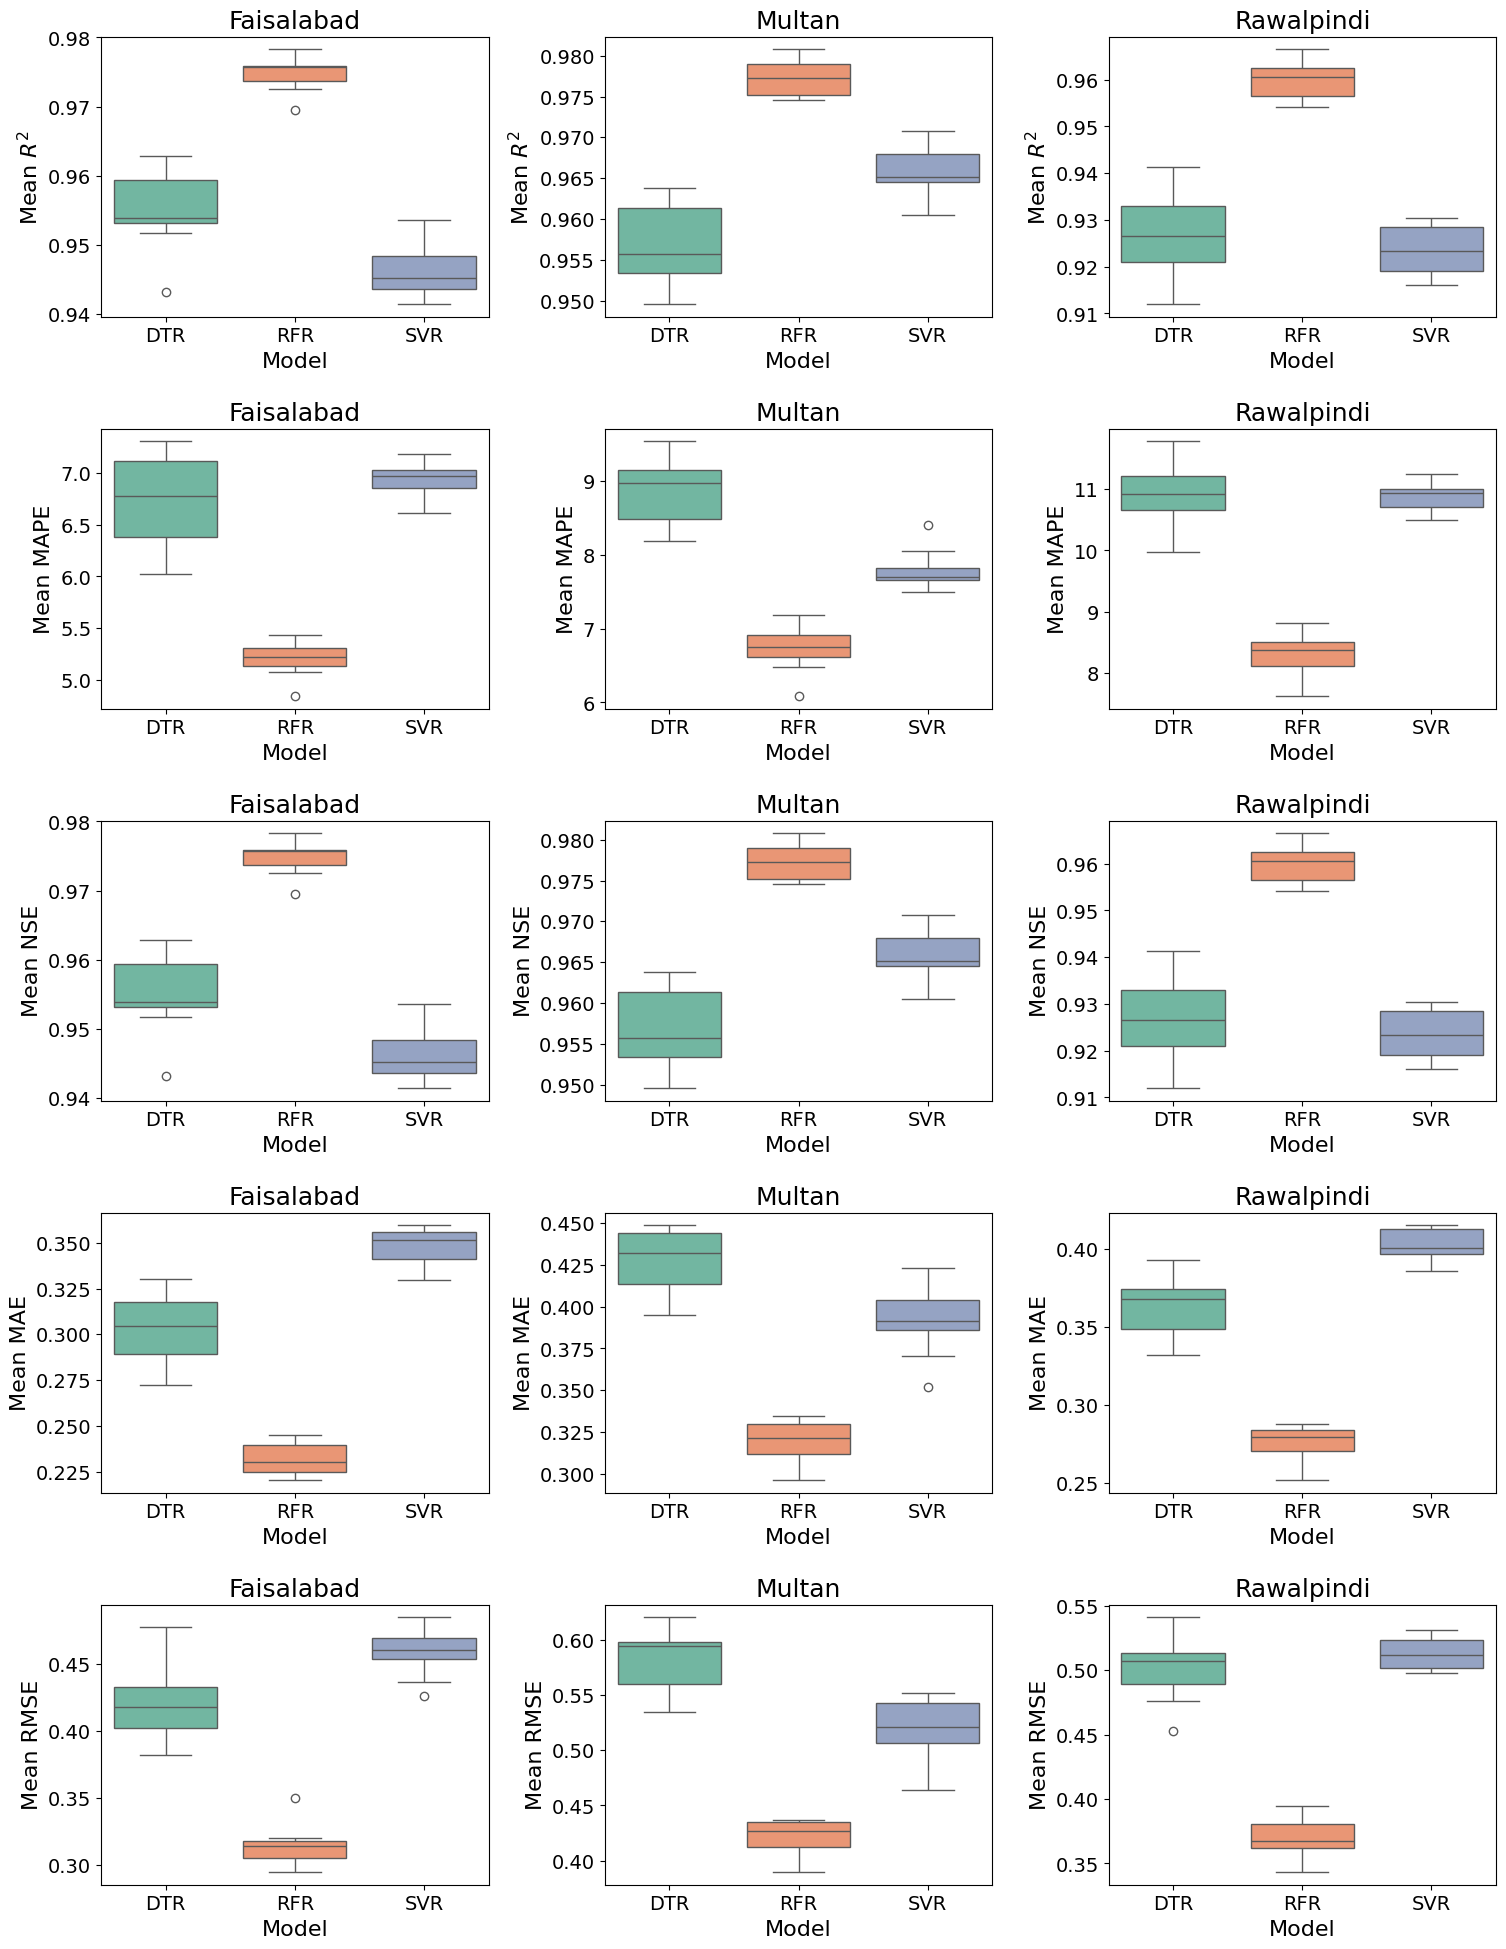

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

def nash_sutcliffe_efficiency(y_true, y_pred):
    """
    Calculate the Nash–Sutcliffe model efficiency coefficient (NSE).
    """
    return 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load and preprocess each dataset (FsdET, MtnET, RwlET)
datasets = ['FsdET.csv', 'MtnET.csv', 'RwpET.csv']
models = []

# Initialize a dictionary to store evaluation metrics for each model
evaluation_metrics = {}

model_mapping = {
    'DecisionTreeRegressor': 'DTR',
    'RandomForestRegressor': 'RFR',
    'SVR': 'SVR'
}

for dataset_name in datasets:
    df = pd.read_csv(dataset_name)
    selected_features = ['Tmax', 'WS', 'RH']
    X = df[selected_features]
    y = df['ETo']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Decision Tree Regressor model
    dtr_model = DecisionTreeRegressor(random_state=42)
    dtr_model.fit(X_train, y_train)
    models.append(dtr_model)

    # Initialize and train the Random Forest Regressor model
    rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rfr_model.fit(X_train, y_train)
    models.append(rfr_model)

    # Initialize and train the Support Vector Regressor model
    svr_model = SVR(kernel='linear')
    svr_model.fit(X_train, y_train)
    models.append(svr_model)

    # Make predictions using individual models
    for model in models:
        y_pred = model.predict(X_test)

        # Evaluate the model
        model_name = type(model).__name__
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        nse = nash_sutcliffe_efficiency(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        # Store evaluation metrics in the dictionary
        if model_name in evaluation_metrics:
            evaluation_metrics[model_name]['R-squared'].append(r2)
            evaluation_metrics[model_name]['RMSE'].append(rmse)
            evaluation_metrics[model_name]['MAE'].append(mae)
            evaluation_metrics[model_name]['NSE'].append(nse)
            evaluation_metrics[model_name]['MAPE'].append(mape)
        else:
            evaluation_metrics[model_name] = {
                'R-squared': [r2],
                'RMSE': [rmse],
                'MAE': [mae],
                'NSE': [nse],
                'MAPE': [mape]
            }

# Calculate the mean of the evaluation metrics
mean_metrics = {}
for model_name, metrics in evaluation_metrics.items():
    mean_metrics[model_name] = {
        metric_name: np.mean(metric_values) for metric_name, metric_values in metrics.items()
    }

# Convert mean_metrics dictionary to DataFrame
mean_metrics_df = pd.DataFrame(mean_metrics).T

# Rename the columns to match the radar plot labels
mean_metrics_df.columns = ['R²', 'RMSE', 'MAE', 'NSE', 'MAPE']

# Print the mean evaluation metrics for each model
for model_name, metrics in mean_metrics.items():
    print(f"Mean Metrics for {model_mapping[model_name]}:")
    for metric_name, mean_value in metrics.items():
        print(f"{metric_name}: {mean_value:.4f}")
    print()

# Gather evaluation metrics in a DataFrame
metrics_data = []

for model_name, metrics in evaluation_metrics.items():
    for i in range(len(metrics['R-squared'])):
        metrics_data.append({
            'Model': model_mapping[model_name],
            'R²': metrics['R-squared'][i],
            'RMSE': metrics['RMSE'][i],
            'MAE': metrics['MAE'][i],
            'NSE': metrics['NSE'][i],
            'MAPE': metrics['MAPE'][i]
        })

metrics_df = pd.DataFrame(metrics_data)

# Create box plots for each metric
plt.figure(figsize=(18, 12))

palette = sns.color_palette("tab10", len(model_mapping))  # Different colors for each model

metrics = ['R²', 'RMSE', 'MAE', 'NSE', 'MAPE']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Model', y=metric, data=metrics_df, palette=palette)
    plt.title(f'{chr(64+i)}) Comparison of {metric} across Models', fontsize=20)
    plt.xlabel('', fontsize=20)
    plt.ylabel(metric, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()

# Radar plot
def create_radar_chart(df, title, labels):
    num_vars = len(labels)

    # Compute angle of each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Complete the loop
    angles += angles[:1]

    # Initialise the radar plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for i, (model, row) in enumerate(df.iterrows()):
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_mapping[model])
        ax.fill(angles, values, alpha=0.25)

    # Draw one axe per variable + add labels
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=15)

    # Add a title
    ax.set_title(title, size=20, color='black', y=1.1)

    # Add a legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=15)

    plt.show()

# Define labels for the metrics
labels = ['R²', 'RMSE', 'MAE', 'NSE', 'MAPE']

mean_metrics_df['MAPE'] /= 100
#mape scalled to
# Create the radar plot
create_radar_chart(mean_metrics_df, 'Comparison of Mean Metrics of Federated Models', labels)



**Make here radar plot of locals models (remianing)**

Fedrated MOdel

Mean Metrics for DecisionTreeRegressor:
R-squared: 0.9150
RMSE: 0.6359
MAE: 0.4768
NSE: 0.9150
MAPE: 12.4930

Mean Metrics for RandomForestRegressor:
R-squared: 0.9481
RMSE: 0.4887
MAE: 0.3815
NSE: 0.9481
MAPE: 10.3527

Mean Metrics for SVR:
R-squared: 0.9110
RMSE: 0.6458
MAE: 0.5253
NSE: 0.9110
MAPE: 14.8805



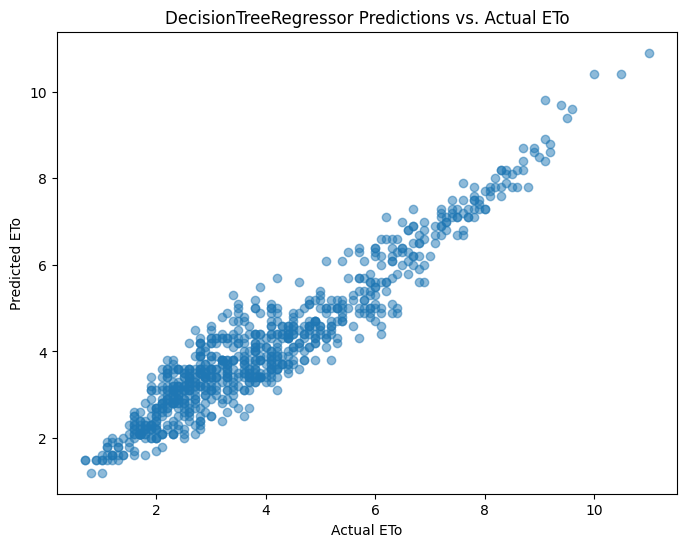

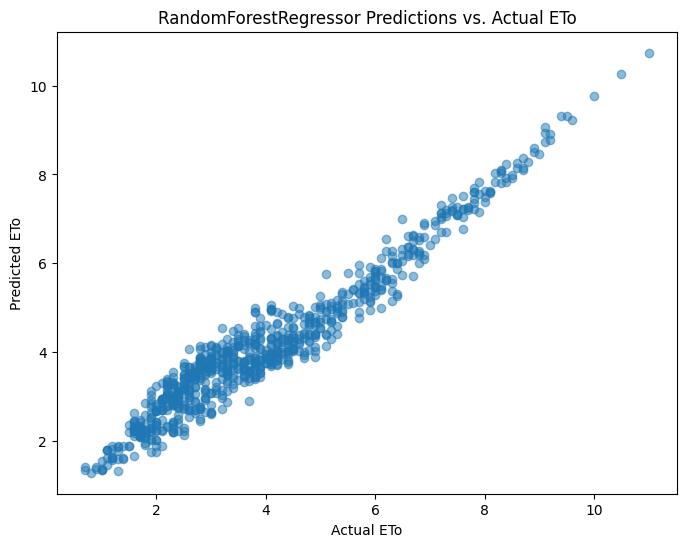

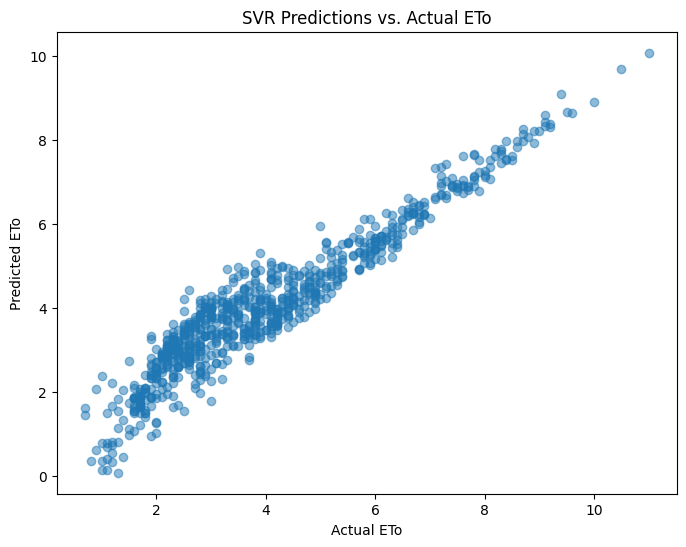

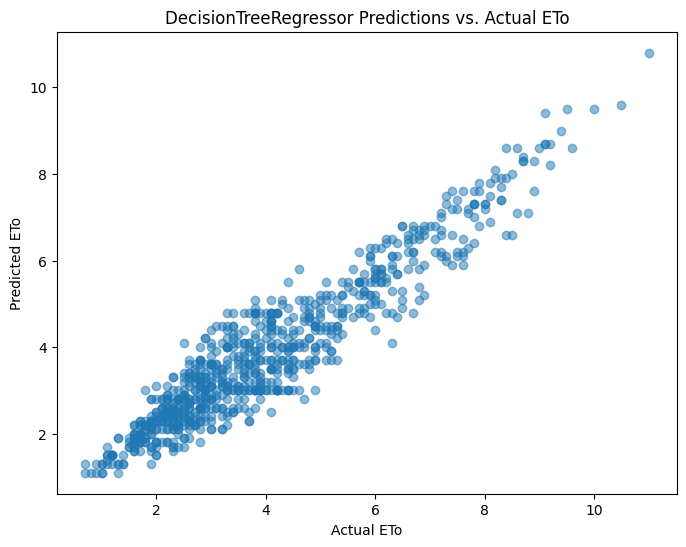

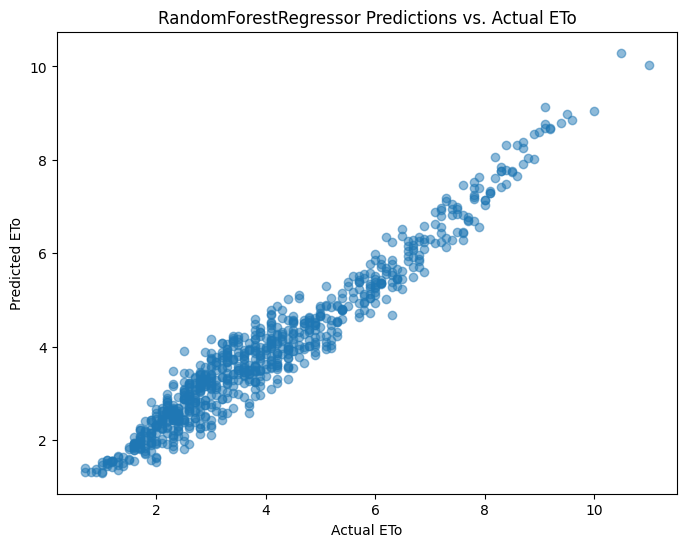

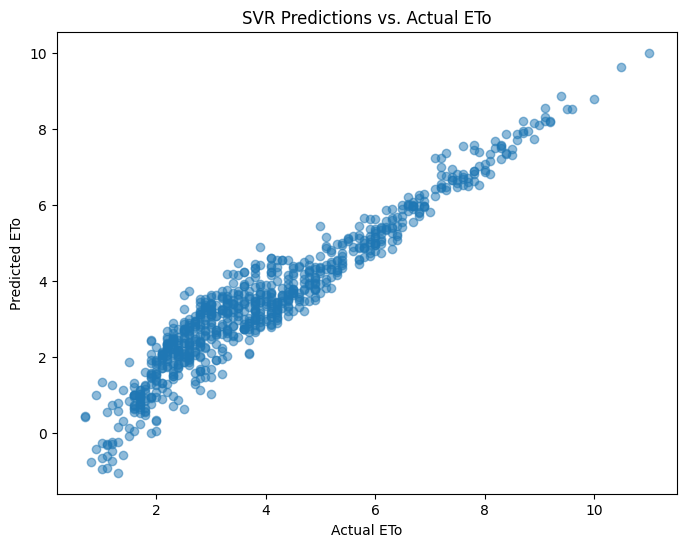

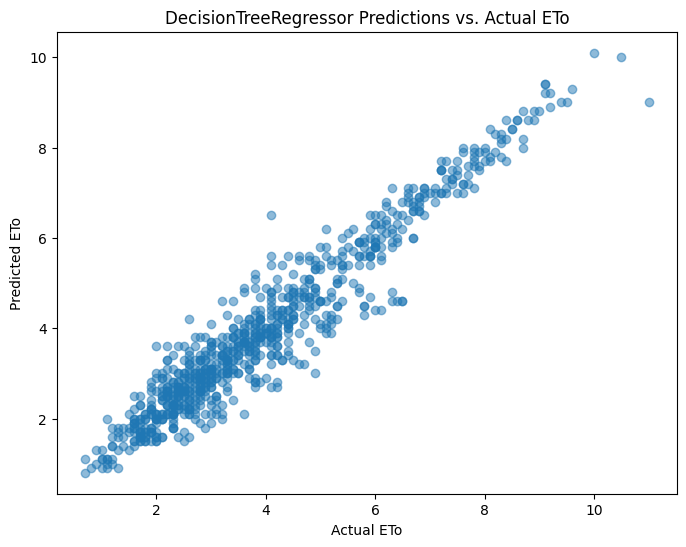

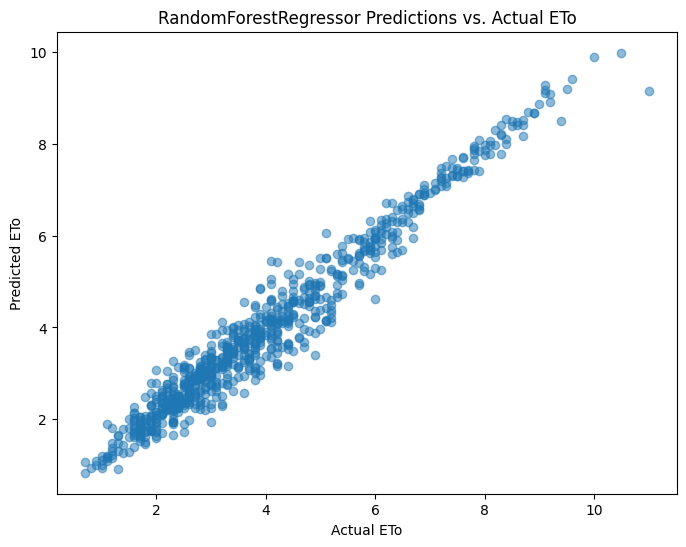

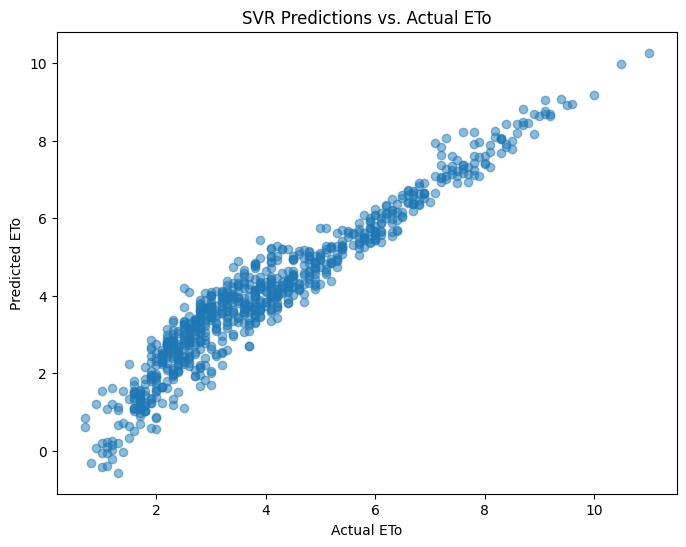

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def nash_sutcliffe_efficiency(y_true, y_pred):
    """
    Calculate the Nash–Sutcliffe model efficiency coefficient (NSE).
    """
    return 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load and preprocess each dataset (FsdET, MtnET, RwlET)
datasets = ['FsdET.csv', 'MtnET.csv', 'RwpET.csv']
models = []

# Initialize a dictionary to store evaluation metrics for each model
evaluation_metrics = {}

for dataset_name in datasets:
    df = pd.read_csv(dataset_name)
    selected_features = ['Tmax', 'WS', 'RH']
    X = df[selected_features]
    y = df['ETo']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Decision Tree Regressor model
    dtr_model = DecisionTreeRegressor(random_state=42)
    dtr_model.fit(X_train, y_train)
    models.append(dtr_model)

    # Initialize and train the Random Forest Regressor model
    rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rfr_model.fit(X_train, y_train)
    models.append(rfr_model)

    # Initialize and train the Support Vector Regressor model
    svr_model = SVR(kernel='linear')
    svr_model.fit(X_train, y_train)
    models.append(svr_model)

    # Make predictions using individual models
    for model in models:
        y_pred = model.predict(X_test)

        # Evaluate the model
        model_name = type(model).__name__
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        nse = nash_sutcliffe_efficiency(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        # Store evaluation metrics in the dictionary
        if model_name in evaluation_metrics:
            evaluation_metrics[model_name]['R-squared'].append(r2)
            evaluation_metrics[model_name]['RMSE'].append(rmse)
            evaluation_metrics[model_name]['MAE'].append(mae)
            evaluation_metrics[model_name]['NSE'].append(nse)
            evaluation_metrics[model_name]['MAPE'].append(mape)
        else:
            evaluation_metrics[model_name] = {
                'R-squared': [r2],
                'RMSE': [rmse],
                'MAE': [mae],
                'NSE': [nse],
                'MAPE': [mape]
            }

# Calculate the mean of the evaluation metrics
mean_metrics = {}
for model_name, metrics in evaluation_metrics.items():
    mean_metrics[model_name] = {
        metric_name: np.mean(metric_values) for metric_name, metric_values in metrics.items()
    }

# Print the mean evaluation metrics for each model
for model_name, metrics in mean_metrics.items():
    print(f"Mean Metrics for {model_name}:")
    for metric_name, mean_value in metrics.items():
        print(f"{metric_name}: {mean_value:.4f}")
    print()

# Plot predicted vs. actual values for each model
for model in models:
    model_name = type(model).__name__
    y_pred = model.predict(X_test)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual ETo")
    plt.ylabel("Predicted ETo")
    plt.title(f"{model_name} Predictions vs. Actual ETo")
    plt.show()


Mean Metrics for DTR:
R-squared: 0.9150
RMSE: 0.6359
MAE: 0.4768
NSE: 0.9150
MAPE: 12.4930

Mean Metrics for RFR:
R-squared: 0.9481
RMSE: 0.4887
MAE: 0.3815
NSE: 0.9481
MAPE: 10.3527

Mean Metrics for SVR:
R-squared: 0.9110
RMSE: 0.6458
MAE: 0.5253
NSE: 0.9110
MAPE: 14.8805



<ipython-input-18-339a16835906>:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y=metric, data=metrics_df, palette=palette)
<ipython-input-18-339a16835906>:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y=metric, data=metrics_df, palette=palette)
<ipython-input-18-339a16835906>:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y=metric, data=metrics_df, palette=palette)
<ipython-input-18-339a16835906>:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in 

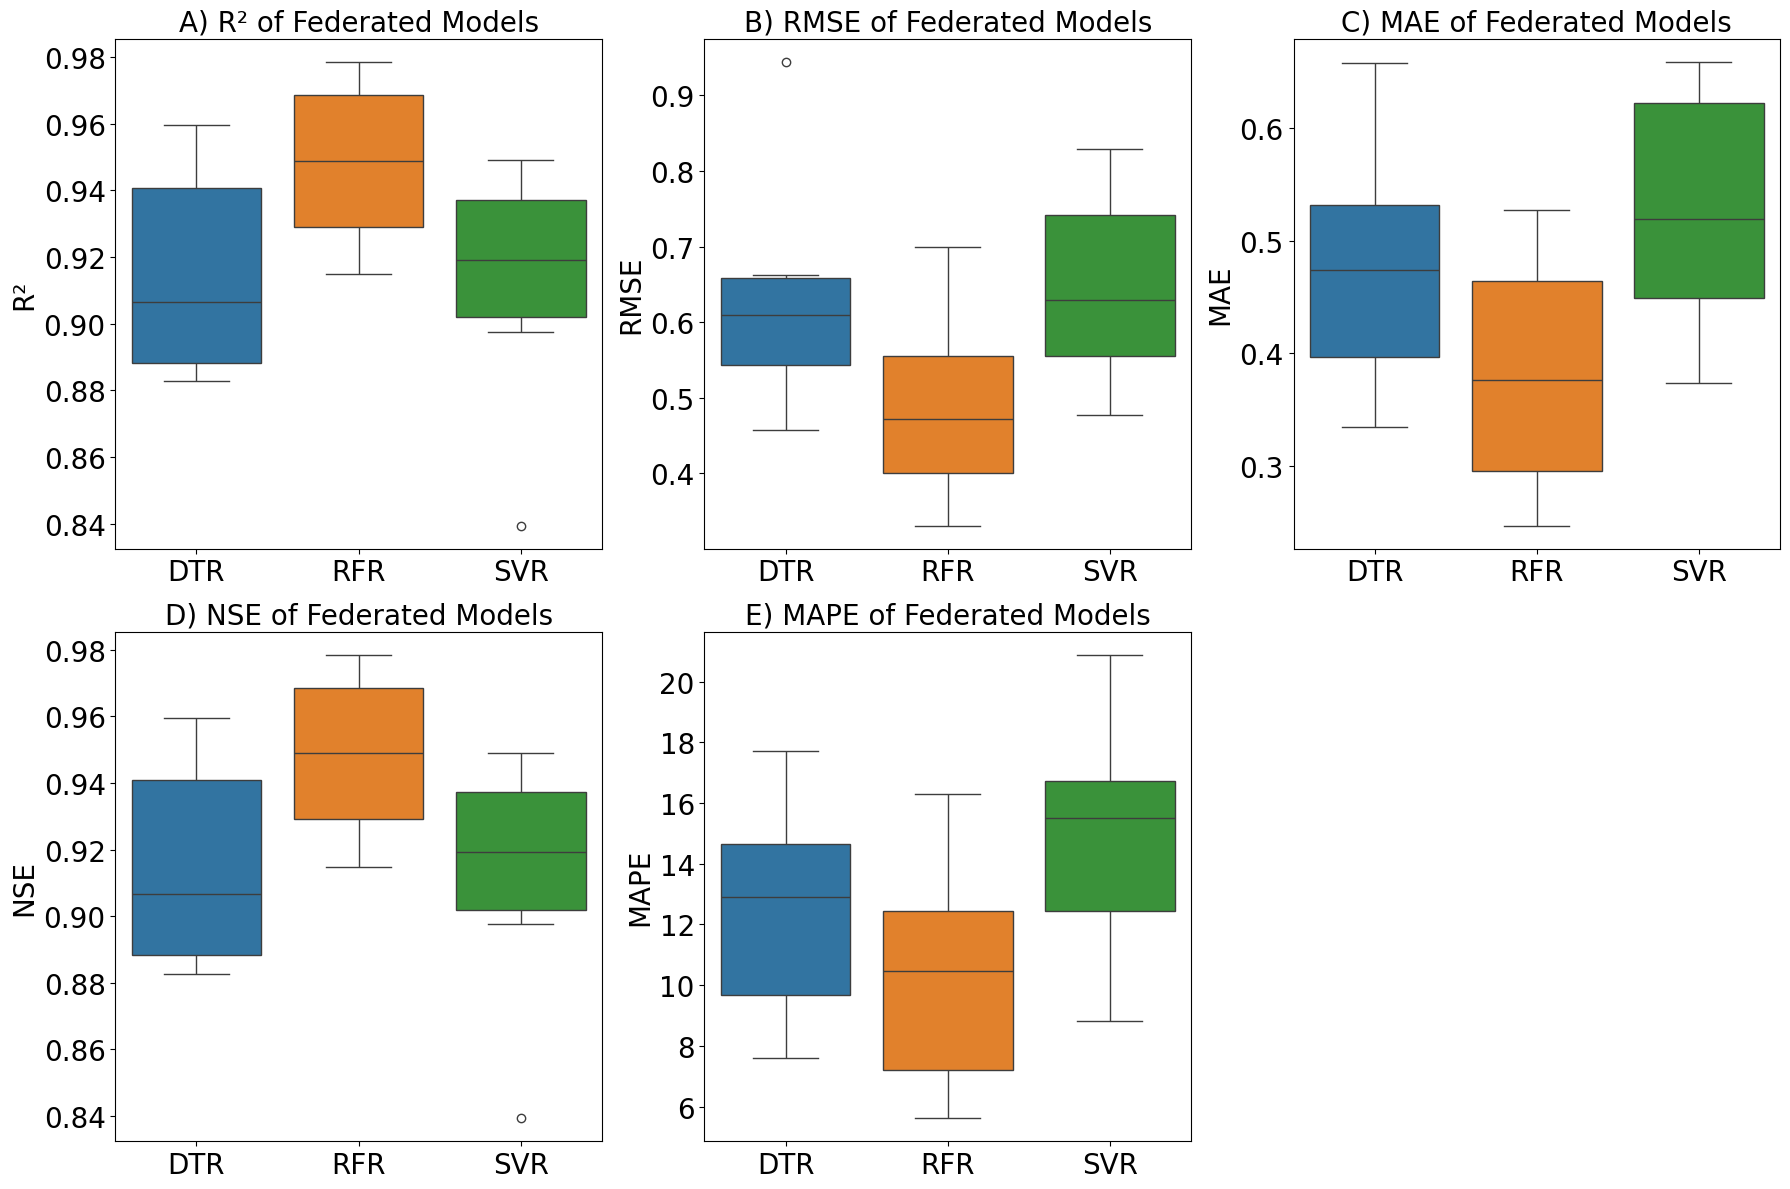

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

def nash_sutcliffe_efficiency(y_true, y_pred):
    """
    Calculate the Nash–Sutcliffe model efficiency coefficient (NSE).
    """
    return 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load and preprocess each dataset (FsdET, MtnET, RwlET)
datasets = ['FsdET.csv', 'MtnET.csv', 'RwpET.csv']
models = []

# Initialize a dictionary to store evaluation metrics for each model
evaluation_metrics = {}

model_mapping = {
    'DecisionTreeRegressor': 'DTR',
    'RandomForestRegressor': 'RFR',
    'SVR': 'SVR'
}

for dataset_name in datasets:
    df = pd.read_csv(dataset_name)
    selected_features = ['Tmax', 'WS', 'RH']
    X = df[selected_features]
    y = df['ETo']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Decision Tree Regressor model
    dtr_model = DecisionTreeRegressor(random_state=42)
    dtr_model.fit(X_train, y_train)
    models.append(dtr_model)

    # Initialize and train the Random Forest Regressor model
    rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rfr_model.fit(X_train, y_train)
    models.append(rfr_model)

    # Initialize and train the Support Vector Regressor model
    svr_model = SVR(kernel='linear')
    svr_model.fit(X_train, y_train)
    models.append(svr_model)

    # Make predictions using individual models
    for model in models:
        y_pred = model.predict(X_test)

        # Evaluate the model
        model_name = type(model).__name__
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        nse = nash_sutcliffe_efficiency(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        # Store evaluation metrics in the dictionary
        if model_name in evaluation_metrics:
            evaluation_metrics[model_name]['R-squared'].append(r2)
            evaluation_metrics[model_name]['RMSE'].append(rmse)
            evaluation_metrics[model_name]['MAE'].append(mae)
            evaluation_metrics[model_name]['NSE'].append(nse)
            evaluation_metrics[model_name]['MAPE'].append(mape)
        else:
            evaluation_metrics[model_name] = {
                'R-squared': [r2],
                'RMSE': [rmse],
                'MAE': [mae],
                'NSE': [nse],
                'MAPE': [mape]
            }

# Calculate the mean of the evaluation metrics
mean_metrics = {}
for model_name, metrics in evaluation_metrics.items():
    mean_metrics[model_name] = {
        metric_name: np.mean(metric_values) for metric_name, metric_values in metrics.items()
    }

# Print the mean evaluation metrics for each model
for model_name, metrics in mean_metrics.items():
    print(f"Mean Metrics for {model_mapping[model_name]}:")
    for metric_name, mean_value in metrics.items():
        print(f"{metric_name}: {mean_value:.4f}")
    print()

# Gather evaluation metrics in a DataFrame
metrics_data = []

for model_name, metrics in evaluation_metrics.items():
    for i in range(len(metrics['R-squared'])):
        metrics_data.append({
            'Model': model_mapping[model_name],
            'R²': metrics['R-squared'][i],
            'RMSE': metrics['RMSE'][i],
            'MAE': metrics['MAE'][i],
            'NSE': metrics['NSE'][i],
            'MAPE': metrics['MAPE'][i]
        })

metrics_df = pd.DataFrame(metrics_data)

# Create box plots for each metric
plt.figure(figsize=(18, 12))

palette = sns.color_palette("tab10", len(model_mapping))  # Different colors for each model

metrics = ['R²', 'RMSE', 'MAE', 'NSE', 'MAPE']
titles = ['A) R² of Federated Models', 'B) RMSE of Federated Models',
          'C) MAE of Federated Models', 'D) NSE of Federated Models',
          'E) MAPE of Federated Models']

for i, (metric, title) in enumerate(zip(metrics, titles), 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Model', y=metric, data=metrics_df, palette=palette)
    plt.title(title, fontsize=20)
    plt.xlabel('', fontsize=20)
    plt.ylabel(metric, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()



Mean Metrics for DTR:
R-squared: 0.9150
RMSE: 0.6359
MAE: 0.4768
NSE: 0.9150
MAPE: 12.4930

Mean Metrics for RFR:
R-squared: 0.9481
RMSE: 0.4887
MAE: 0.3815
NSE: 0.9481
MAPE: 10.3527

Mean Metrics for SVR:
R-squared: 0.9110
RMSE: 0.6458
MAE: 0.5253
NSE: 0.9110
MAPE: 14.8805



<ipython-input-32-005b0743c976>:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y=metric, data=metrics_df, palette=palette)
<ipython-input-32-005b0743c976>:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y=metric, data=metrics_df, palette=palette)
<ipython-input-32-005b0743c976>:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y=metric, data=metrics_df, palette=palette)
<ipython-input-32-005b0743c976>:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in 

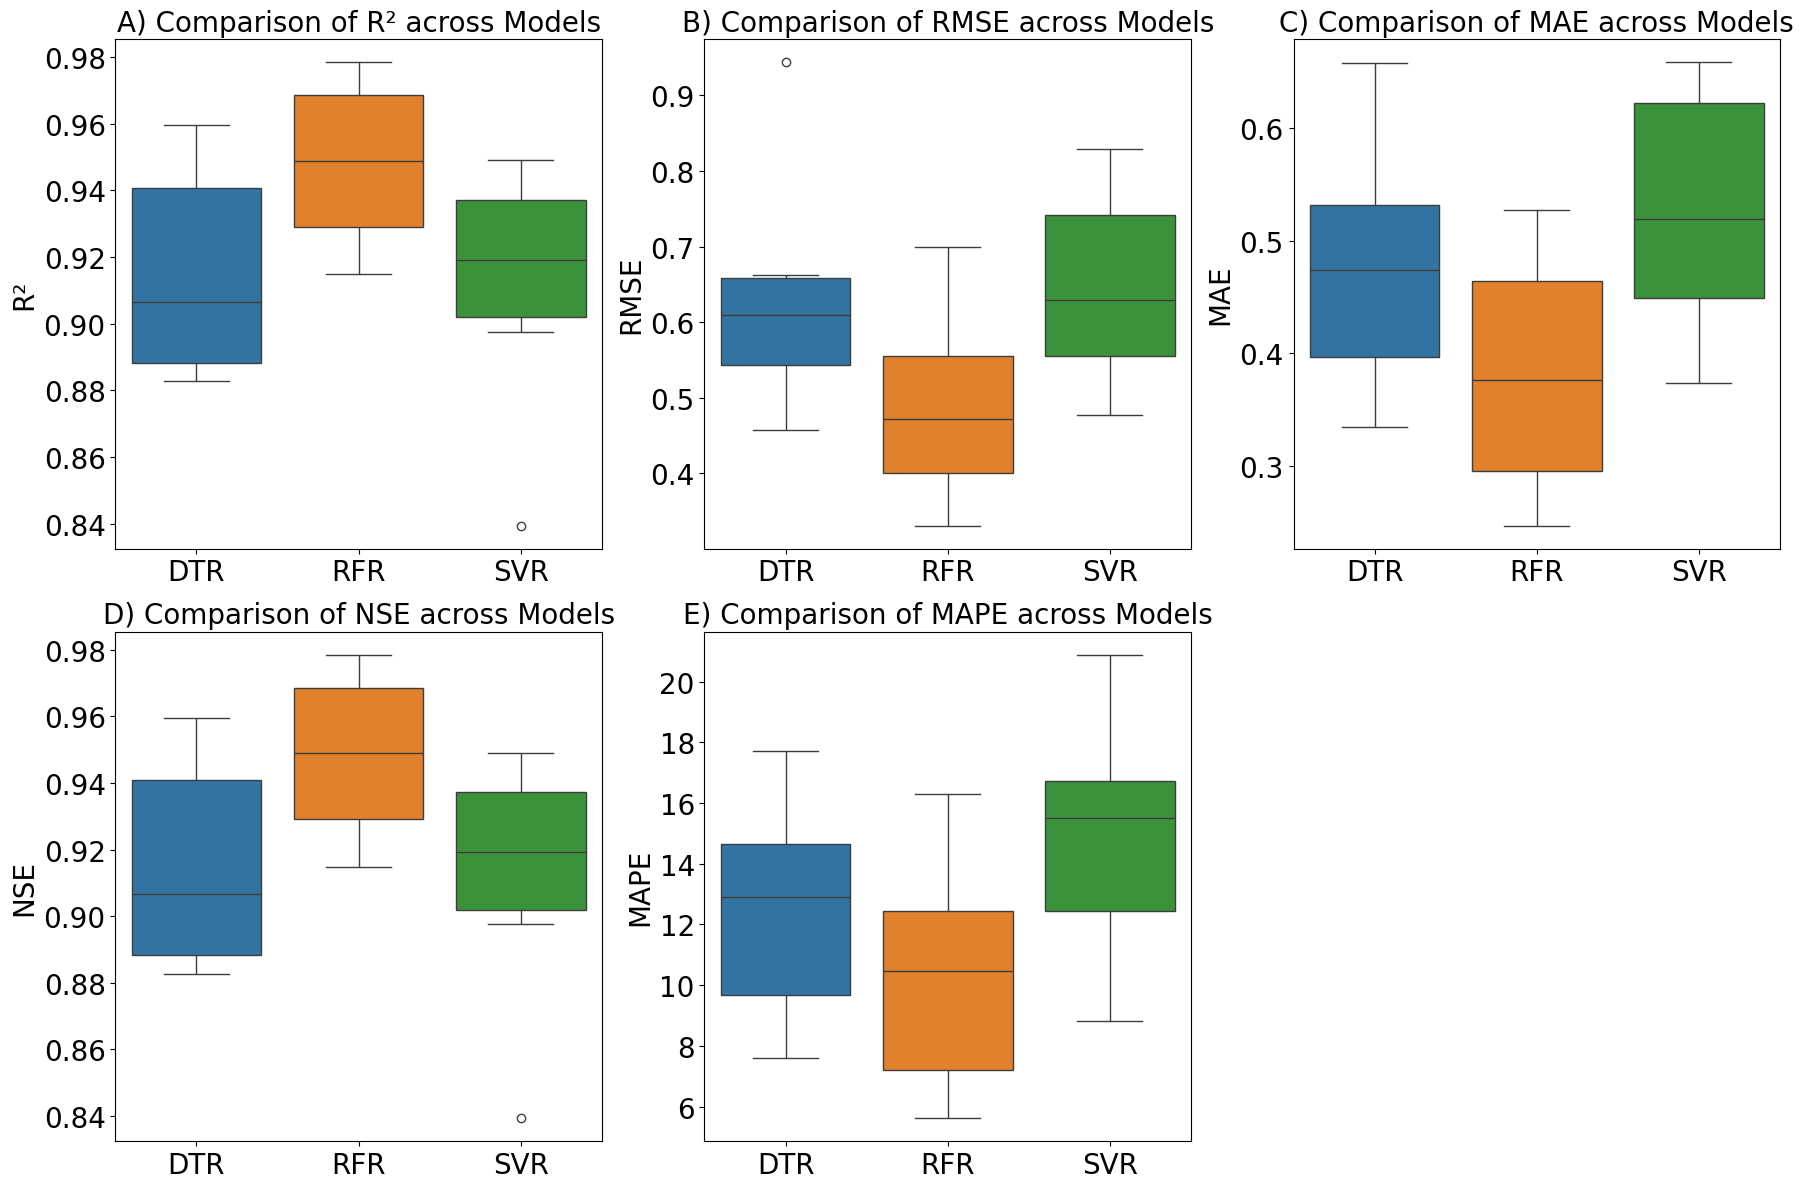

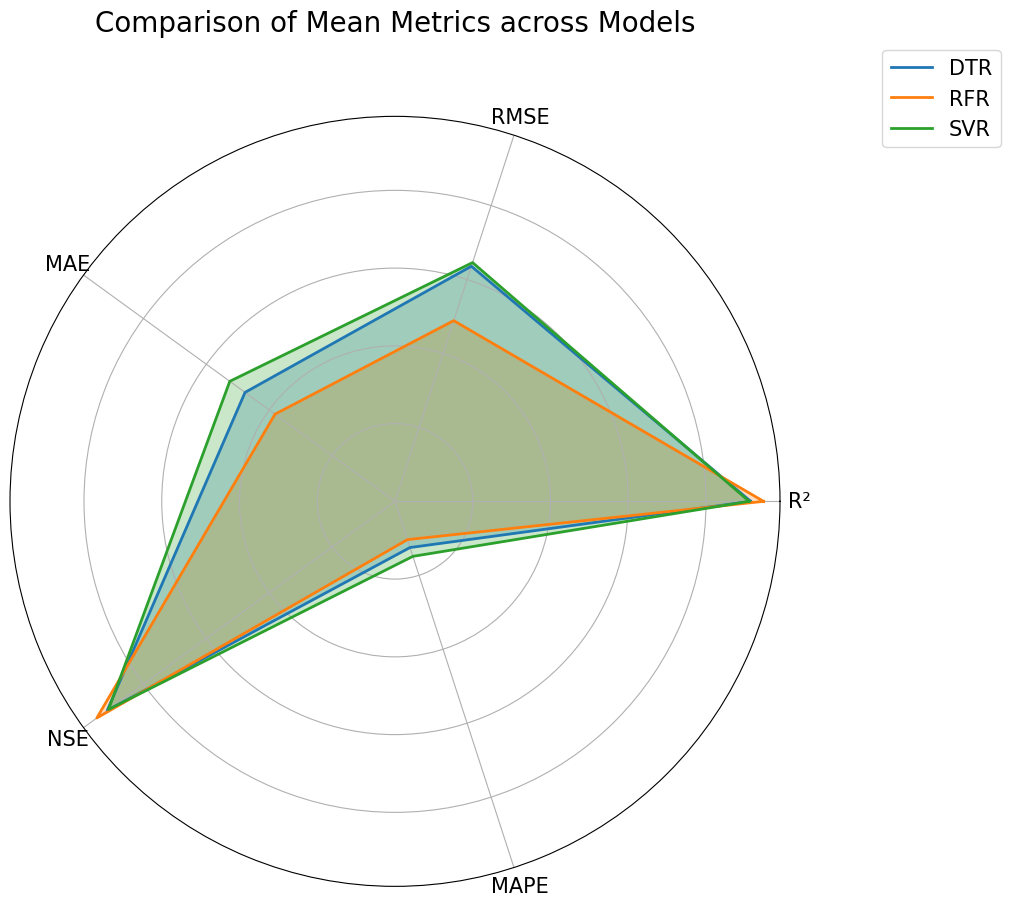

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

def nash_sutcliffe_efficiency(y_true, y_pred):
    """
    Calculate the Nash–Sutcliffe model efficiency coefficient (NSE).
    """
    return 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load and preprocess each dataset (FsdET, MtnET, RwlET)
datasets = ['FsdET.csv', 'MtnET.csv', 'RwpET.csv']
models = []

# Initialize a dictionary to store evaluation metrics for each model
evaluation_metrics = {}

model_mapping = {
    'DecisionTreeRegressor': 'DTR',
    'RandomForestRegressor': 'RFR',
    'SVR': 'SVR'
}

for dataset_name in datasets:
    df = pd.read_csv(dataset_name)
    selected_features = ['Tmax', 'WS', 'RH']
    X = df[selected_features]
    y = df['ETo']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the Decision Tree Regressor model
    dtr_model = DecisionTreeRegressor(random_state=42)
    dtr_model.fit(X_train, y_train)
    models.append(dtr_model)

    # Initialize and train the Random Forest Regressor model
    rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rfr_model.fit(X_train, y_train)
    models.append(rfr_model)

    # Initialize and train the Support Vector Regressor model
    svr_model = SVR(kernel='linear')
    svr_model.fit(X_train, y_train)
    models.append(svr_model)

    # Make predictions using individual models
    for model in models:
        y_pred = model.predict(X_test)

        # Evaluate the model
        model_name = type(model).__name__
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        nse = nash_sutcliffe_efficiency(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)

        # Store evaluation metrics in the dictionary
        if model_name in evaluation_metrics:
            evaluation_metrics[model_name]['R-squared'].append(r2)
            evaluation_metrics[model_name]['RMSE'].append(rmse)
            evaluation_metrics[model_name]['MAE'].append(mae)
            evaluation_metrics[model_name]['NSE'].append(nse)
            evaluation_metrics[model_name]['MAPE'].append(mape)
        else:
            evaluation_metrics[model_name] = {
                'R-squared': [r2],
                'RMSE': [rmse],
                'MAE': [mae],
                'NSE': [nse],
                'MAPE': [mape]
            }

# Calculate the mean of the evaluation metrics
mean_metrics = {}
for model_name, metrics in evaluation_metrics.items():
    mean_metrics[model_name] = {
        metric_name: np.mean(metric_values) for metric_name, metric_values in metrics.items()
    }

# Convert mean_metrics dictionary to DataFrame
mean_metrics_df = pd.DataFrame(mean_metrics).T

# Rename the columns to match the radar plot labels
mean_metrics_df.columns = ['R²', 'RMSE', 'MAE', 'NSE', 'MAPE']

# Print the mean evaluation metrics for each model
for model_name, metrics in mean_metrics.items():
    print(f"Mean Metrics for {model_mapping[model_name]}:")
    for metric_name, mean_value in metrics.items():
        print(f"{metric_name}: {mean_value:.4f}")
    print()

# Gather evaluation metrics in a DataFrame
metrics_data = []

for model_name, metrics in evaluation_metrics.items():
    for i in range(len(metrics['R-squared'])):
        metrics_data.append({
            'Model': model_mapping[model_name],
            'R²': metrics['R-squared'][i],
            'RMSE': metrics['RMSE'][i],
            'MAE': metrics['MAE'][i],
            'NSE': metrics['NSE'][i],
            'MAPE': metrics['MAPE'][i]
        })

metrics_df = pd.DataFrame(metrics_data)

# Create box plots for each metric
plt.figure(figsize=(18, 12))

palette = sns.color_palette("tab10", len(model_mapping))  # Different colors for each model

metrics = ['R²', 'RMSE', 'MAE', 'NSE', 'MAPE']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Model', y=metric, data=metrics_df, palette=palette)
    plt.title(f'{chr(64+i)}) Comparison of {metric} across Models', fontsize=20)
    plt.xlabel('', fontsize=20)
    plt.ylabel(metric, fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()

# Radar plot
def create_radar_chart(df, title, labels):
    num_vars = len(labels)

    # Compute angle of each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Complete the loop
    angles += angles[:1]

    # Initialise the radar plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for i, (model, row) in enumerate(df.iterrows()):
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_mapping[model])
        ax.fill(angles, values, alpha=0.25)

    # Draw one axe per variable + add labels
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=15)

    # Add a title
    ax.set_title(title, size=20, color='black', y=1.1)

    # Add a legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=15)

    plt.show()

# Define labels for the metrics
labels = ['R²', 'RMSE', 'MAE', 'NSE', 'MAPE']

mean_metrics_df['MAPE'] /= 100
#mape scalled to
# Create the radar plot
create_radar_chart(mean_metrics_df, 'Comparison of Mean Metrics of Federated Models', labels)

In [ ]:
Make smith Diagram of Federated models (if possible)



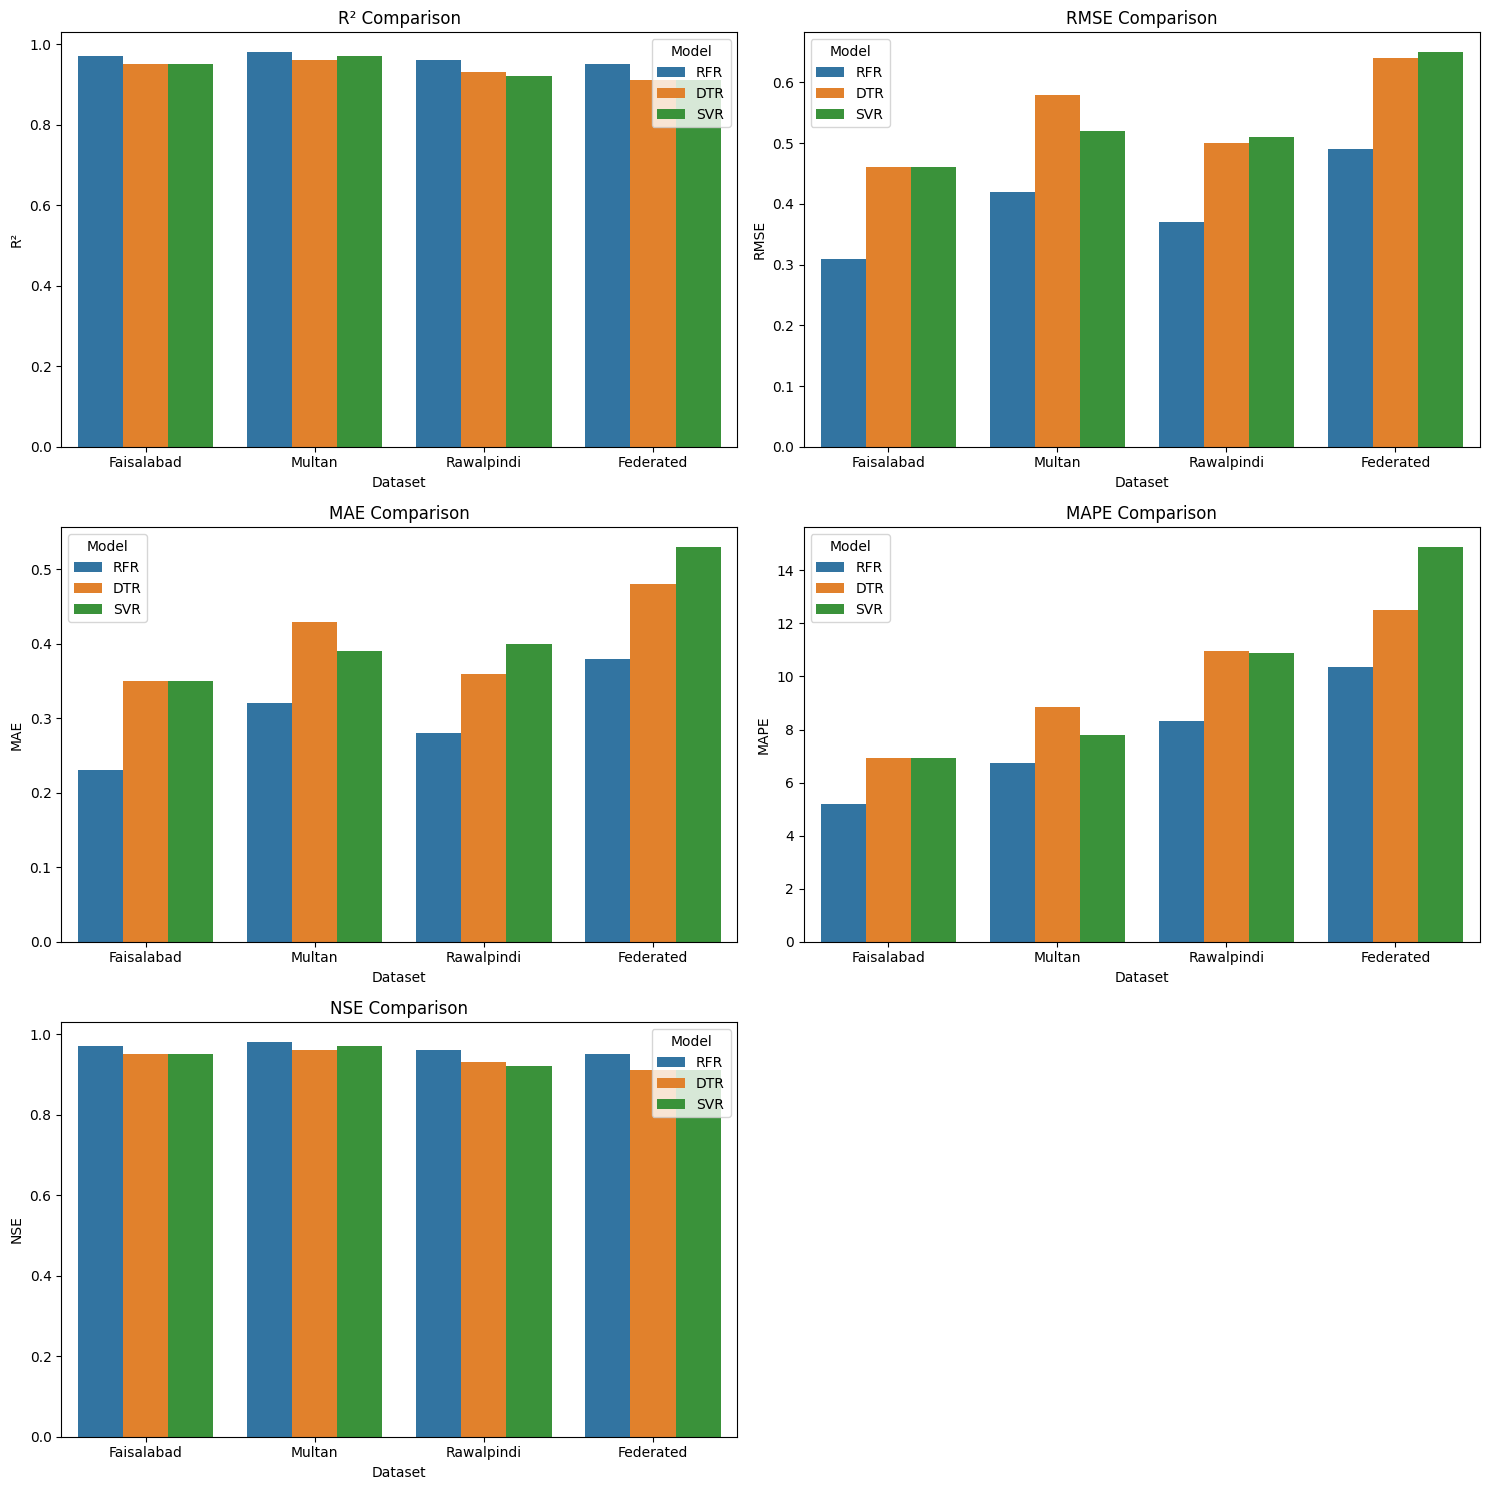

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data from the table
data = {
    'Model': ['RFR', 'DTR', 'SVR', 'RFR', 'DTR', 'SVR', 'RFR', 'DTR', 'SVR', 'RFR', 'DTR', 'SVR'],
    'Dataset': ['Faisalabad', 'Faisalabad', 'Faisalabad', 'Multan', 'Multan', 'Multan', 'Rawalpindi', 'Rawalpindi', 'Rawalpindi', 'Federated', 'Federated', 'Federated'],
    'R2': [0.97, 0.95, 0.95, 0.98, 0.96, 0.97, 0.96, 0.93, 0.92, 0.95, 0.91, 0.91],
    'RMSE': [0.31, 0.46, 0.46, 0.42, 0.58, 0.52, 0.37, 0.5, 0.51, 0.49, 0.64, 0.65],
    'MAE': [0.23, 0.35, 0.35, 0.32, 0.43, 0.39, 0.28, 0.36, 0.4, 0.38, 0.48, 0.53],
    'MAPE': [5.21, 6.93, 6.93, 6.72, 8.86, 7.79, 8.31, 10.95, 10.88, 10.35, 12.49, 14.88],
    'NSE': [0.97, 0.95, 0.95, 0.98, 0.96, 0.97, 0.96, 0.93, 0.92, 0.95, 0.91, 0.91]
}

df = pd.DataFrame(data)

# Set up the figure and axes
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot R² Comparison
sns.barplot(x='Dataset', y='R2', hue='Model', data=df, ax=axs[0, 0])
axs[0, 0].set_title('R² Comparison')
axs[0, 0].set_ylabel('R²')

# Plot RMSE Comparison
sns.barplot(x='Dataset', y='RMSE', hue='Model', data=df, ax=axs[0, 1])
axs[0, 1].set_title('RMSE Comparison')
axs[0, 1].set_ylabel('RMSE')

# Plot MAE Comparison
sns.barplot(x='Dataset', y='MAE', hue='Model', data=df, ax=axs[1, 0])
axs[1, 0].set_title('MAE Comparison')
axs[1, 0].set_ylabel('MAE')

# Plot MAPE Comparison
sns.barplot(x='Dataset', y='MAPE', hue='Model', data=df, ax=axs[1, 1])
axs[1, 1].set_title('MAPE Comparison')
axs[1, 1].set_ylabel('MAPE')

# Plot NSE Comparison
sns.barplot(x='Dataset', y='NSE', hue='Model', data=df, ax=axs[2, 0])
axs[2, 0].set_title('NSE Comparison')
axs[2, 0].set_ylabel('NSE')

# Remove the empty subplot
fig.delaxes(axs[2, 1])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
